# IMPORTS

In [2]:
import pandas as pd
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, recall_score, precision_score, precision_recall_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split


# DATA EXPLAIN AND PREPARATION

Данные берем из этого датасета Kaggle https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction

### [!] DISCLAMER

В моем учебном примере стоит задача улучшения кредитного скоринга у банка-стартапа, то есть текущая ситуация говорит о том,  что дефолтящих клиентов достаточно много, так как используется эвристические методы для скоринга клиентов (по сути эфвристическое решающее дерево).


В самом датасете дефолтящих клиентов очень мало, меньше 1%, что не соответствует исходому состоянию и бизнес-задаче. Поэтому в датасет будет замешано немного синтетики для приведения пропорции классов к бизнес-логике задания. 
Для достижения целевой пропорции возьмем весь датасет и используем для 1 класса метод SMOTE. Также, чтобы не добавлять слишком много синтетеики будет использован андерсемлинг через TomekLinks, чтобы убрать самые шумные наблюдения из 0 класса.

Далее уберем случайные записи из класса 1 чтобы получилась целевая пропорция 0.1.
Предполагается, что на проде мы будем видеть именно такие данные.

### Features

In [223]:
df = pd.read_csv('data/application_record.csv', sep=',')

In [5]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [6]:
df.shape

(438557, 18)

**Feature description** - https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction/discussion/119320

### Target

#### Для скачивания таргета уже надо перейти на стрраницу Kaggle
https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction/data?select=credit_record.csv

In [7]:
df_target = pd.read_csv('data/credit_record.csv', sep=',')

In [8]:
df_target.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [9]:
df_target.shape

(1048575, 3)

In [222]:
df_target['ID'].nunique()/len(df_target)

0.04385475526309515

**MONTHS_BALANCE** - The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on  

**STATUS** - 0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month

### Выводы об исходных данных
0) Уникальных ID сильно меньше, чем самих записей.
1) Всего у нас почти 440к строк с записями о заемщиках.
2) Есть 18 базовых признаков заемщика таких как: зарплата, наличие недвижимости в собственности, налииче машины, возраст и др.
3) Старгетом интереснее, так как он не бинарный. У нас есть несколько групп пользоватлей по сроку просрочки платежа от 1 до 150+ дней. Также есть группа С, которая не просрочила платеж и группа Х, которая не брала займы и не платила по кредиту в этом месяце.

Для нашего упражнения попробуем бинаризовать таргет, так как для нас важно предсказывать дефолтящих клиентов с просрочкой более 90 дней. Получается в класс 1 попадут юзеры с тегами: 3, 4, 5; а в клсс 0 - остальные, кроме класса Х, так как они вообще не брали заем и таких пользователей мы не планируем скорить на проде.

# EDA

In [226]:
df.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [227]:
# Видим константный признак FLAG_MOBIL, который точно не берем в обучение
df['FLAG_MOBIL'].value_counts()

FLAG_MOBIL
1    438557
Name: count, dtype: int64

In [228]:
df = df.drop(columns=['FLAG_MOBIL'])

In [229]:
df.isna().sum()/len(df)

ID                     0.00000
CODE_GENDER            0.00000
FLAG_OWN_CAR           0.00000
FLAG_OWN_REALTY        0.00000
CNT_CHILDREN           0.00000
AMT_INCOME_TOTAL       0.00000
NAME_INCOME_TYPE       0.00000
NAME_EDUCATION_TYPE    0.00000
NAME_FAMILY_STATUS     0.00000
NAME_HOUSING_TYPE      0.00000
DAYS_BIRTH             0.00000
DAYS_EMPLOYED          0.00000
FLAG_WORK_PHONE        0.00000
FLAG_PHONE             0.00000
FLAG_EMAIL             0.00000
OCCUPATION_TYPE        0.30601
CNT_FAM_MEMBERS        0.00000
dtype: float64

In [230]:
# Видим что 30% в OCCUPATION_TYPE имеют пропуски. Учитывая что это категонриальная фича для професии или сферы занятости,
# то заполним пропуски на "Unknown"
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna('Unknown')

In [231]:
for col in df.select_dtypes(include=['object']).columns:
    print(df[col].value_counts())
    print('\n')

CODE_GENDER
F    294440
M    144117
Name: count, dtype: int64


FLAG_OWN_CAR
N    275459
Y    163098
Name: count, dtype: int64


FLAG_OWN_REALTY
Y    304074
N    134483
Name: count, dtype: int64


NAME_INCOME_TYPE
Working                 226104
Commercial associate    100757
Pensioner                75493
State servant            36186
Student                     17
Name: count, dtype: int64


NAME_EDUCATION_TYPE
Secondary / secondary special    301821
Higher education                 117522
Incomplete higher                 14851
Lower secondary                    4051
Academic degree                     312
Name: count, dtype: int64


NAME_FAMILY_STATUS
Married                 299828
Single / not married     55271
Civil marriage           36532
Separated                27251
Widow                    19675
Name: count, dtype: int64


NAME_HOUSING_TYPE
House / apartment      393831
With parents            19077
Municipal apartment     14214
Rented apartment         5974
Office apartmen

In [232]:
# Есть явные фичи среди numerical которые можно считать категориальными
df.select_dtypes(exclude=['object']).nunique()

ID                  438510
CNT_CHILDREN            12
AMT_INCOME_TOTAL       866
DAYS_BIRTH           16379
DAYS_EMPLOYED         9406
FLAG_WORK_PHONE          2
FLAG_PHONE               2
FLAG_EMAIL               2
CNT_FAM_MEMBERS         13
dtype: int64

In [233]:
# Есть еще CNT_CHILDREN и CNT_FAM_MEMBERS в которых тоже мало уникальных значений, но в базовом варианте оставим их непрерывными фичами
df['FLAG_WORK_PHONE'] = df['FLAG_WORK_PHONE'].astype('string')
df['FLAG_PHONE'] = df['FLAG_PHONE'].astype('string')
df['FLAG_EMAIL'] = df['FLAG_EMAIL'].astype('string')

In [234]:
# Кажется нелогичным что возраст и стаж работы указан в отрицательных числах
# эти фичи лучше сделать положительными
df['DAYS_BIRTH'] = df['DAYS_BIRTH'].abs()
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].abs()


In [235]:
# При этом можно также явно выделить возрастные группы. Зачастую это помогает модели лучше обучиться.
df['AGE_GROUP'] = pd.cut(df['DAYS_BIRTH'] / 365, bins=[0, 18, 25, 35, 45, 55, 65, 100], labels=['0-18', '18-25', '25-35', '35-45', '45-55', '55-65', '65+'])

In [236]:
# В датасете с заемщиками есть дубликаты, посмотрим на них
df['ID'].nunique()/len(df)

0.9998928303504447

In [237]:
df['ID'].value_counts()[df['ID'].value_counts() > 1].shape

(47,)

In [238]:
double_user_list = df['ID'].value_counts()[df['ID'].value_counts() > 1].index

In [239]:
df[df['ID'].isin(double_user_list)].sort_values(by='DAYS_BIRTH').groupby('ID').first()['NAME_INCOME_TYPE'].value_counts()

NAME_INCOME_TYPE
Working                 25
Commercial associate    20
State servant            2
Name: count, dtype: int64

In [240]:
df[df['ID'].isin(double_user_list)].sort_values(by='DAYS_BIRTH').groupby('ID').agg(
    NAME_INCOME_TYPE_FIRST=('NAME_INCOME_TYPE', 'first'),
    NAME_INCOME_TYPE_LAST=('NAME_INCOME_TYPE', 'last'),
)

,NAME_INCOME_TYPE_FIRST,NAME_INCOME_TYPE_LAST
ID,,
7022197,Working,Commercial associate
7022327,Commercial associate,Commercial associate
7023108,Working,Working
7023651,Commercial associate,Commercial associate
7024111,Commercial associate,Working
7036518,Working,Working
7045794,Working,Working
7045885,Commercial associate,Pensioner
7046068,Working,Pensioner


In [241]:
df[df['ID'] == 7282535]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE_GROUP
428166,7282535,F,N,N,1,202500.0,Commercial associate,Secondary / secondary special,Civil marriage,Municipal apartment,16819,521,0,0,0,Laborers,3.0,45-55
433158,7282535,F,N,Y,0,63000.0,Pensioner,Secondary / secondary special,Married,House / apartment,21124,365243,0,1,0,Unknown,2.0,55-65


In [242]:
df[df['ID'] == 7207977]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE_GROUP
427114,7207977,F,N,Y,0,315000.0,Pensioner,Higher education,Married,House / apartment,23688,365243,0,0,0,Unknown,2.0,55-65
427883,7207977,F,N,N,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,16860,1002,0,0,0,High skill tech staff,1.0,45-55


In [243]:
# Судя по всему это люди, которые со временем вышли на пенсию или стал commercial associate
# Но есть и те, кто был в статусе Working и в нем остался
# В этом случае меняется семейное положение
df[df['ID'] == 7742298]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE_GROUP
424819,7742298,F,N,Y,0,144000.0,Working,Secondary / secondary special,Widow,House / apartment,20626,1455,0,0,0,Cooking staff,1.0,55-65
430436,7742298,M,N,N,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,18239,5428,1,0,0,Unknown,2.0,45-55


In [244]:
# Судя пор всему у нас есть запись на некоторых заемщиков в разное время и нвдо понять, какую из них надо взять для нашего таргета.
# Для baseline решения подойдет последняя запись, так как она самая свежая.
df = df.sort_values(by='DAYS_BIRTH').drop_duplicates(subset=['ID'], keep='last')

In [245]:
# Добавляем таргет для обучения
df_target['TARGET'] = df_target['STATUS'].apply(lambda x: 1 if x in ['3', '4', '5'] else 0)

In [246]:
# Видим сильный дисбаланс классов
# Значит будем пробовать сбалансировать классы при обучении, на уровне оверсемлинга и андерсемплинга
# Также попробуем поработать с фильтром выбросов. Вероятно это поможет сделать баланс классов более подходящим для обучения модели
# Также с осторожностью смотрим Accuracy и ROC-AUC, так как они в таких случаях не отражают истинное качество модели
# Вместо них лучше использовать F1-score и PR-AUC
df_target['TARGET'].value_counts(normalize=True)

TARGET
0    0.997868
1    0.002132
Name: proportion, dtype: float64

In [247]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE_GROUP
238,5009058,F,Y,Y,0,112500.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,7489,797,0,1,1,Private service staff,1.0,18-25
391723,6661174,F,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,7678,209,0,0,1,Core staff,1.0,18-25
391724,6661175,F,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,7678,209,0,0,1,Core staff,1.0,18-25
246589,6037220,M,Y,Y,0,80397.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,7680,262,1,1,0,Sales staff,1.0,18-25
246588,6037219,M,Y,Y,0,80397.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,7680,262,1,1,0,Sales staff,1.0,18-25


In [248]:
df_target.head()

,ID,MONTHS_BALANCE,STATUS,TARGET
0,5001711,0,X,0
1,5001711,-1,0,0
2,5001711,-2,0,0
3,5001711,-3,0,0
4,5001712,0,C,0


In [249]:
# Total dataframe. Убираем STATUS так как на его основе мы делали таргет
df_total = pd.merge(df_target.drop('STATUS', axis=1), df, on='ID', how='inner')

In [250]:
df_total.isna().sum()/len(df_total)

ID                     0.0
MONTHS_BALANCE         0.0
TARGET                 0.0
CODE_GENDER            0.0
FLAG_OWN_CAR           0.0
FLAG_OWN_REALTY        0.0
CNT_CHILDREN           0.0
AMT_INCOME_TOTAL       0.0
NAME_INCOME_TYPE       0.0
NAME_EDUCATION_TYPE    0.0
NAME_FAMILY_STATUS     0.0
NAME_HOUSING_TYPE      0.0
DAYS_BIRTH             0.0
DAYS_EMPLOYED          0.0
FLAG_WORK_PHONE        0.0
FLAG_PHONE             0.0
FLAG_EMAIL             0.0
OCCUPATION_TYPE        0.0
CNT_FAM_MEMBERS        0.0
AGE_GROUP              0.0
dtype: float64

In [251]:
df_total.head()

,ID,MONTHS_BALANCE,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE_GROUP
0,5008804,0,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,Unknown,2.0,25-35
1,5008804,-1,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,Unknown,2.0,25-35
2,5008804,-2,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,Unknown,2.0,25-35
3,5008804,-3,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,Unknown,2.0,25-35
4,5008804,-4,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,Unknown,2.0,25-35


In [366]:
# Очень много дубликатов по ID, что при стандартной обработке приведет к leekage
# Поэтому схлопываем данные по ID
df_total['ID'].nunique()/len(df_total)

0.046877069363455766

In [253]:
df_total['ID'].nunique()

36457

In [ ]:
# Берем за таргет признак что юзер дефолтнулся хотя бы раз за весь период кредита
df_target_agg = df_total.sort_values(by=['ID', 'MONTHS_BALANCE']).groupby('ID', as_index=False).agg(
    TARGET=('TARGET', 'max'),
)

In [255]:
df_features_agg = df_total.drop(columns=['MONTHS_BALANCE', 'TARGET'], axis=1).drop_duplicates().reset_index(drop=True)

In [256]:
df_total_agg = pd.merge(df_target_agg, df_features_agg, on='ID', how='inner')

# DISCLAMER SYNTETIC
В этом блоке добавляем в данные немного синтетики и делаем андерсемплинг, чтобы датасет соответстовал описанной бизнес-ситуации.

In [359]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler


In [357]:
oversampler = SMOTE(random_state=42, k_neighbors=10, sampling_strategy='minority')
undersampler = TomekLinks(n_jobs=-1, sampling_strategy='majority')
combine_sampler = SMOTETomek(random_state=42, smote=oversampler, tomek=undersampler, n_jobs=-1)

In [348]:
df_total_agg['DAYS_EMPLOYED_BIN'] = pd.cut(df_total_agg['DAYS_EMPLOYED'], bins=[1, 365, 3*365, 5*365, 10*365, 40*365, df_total_agg['DAYS_EMPLOYED'].max()], labels=['<1 year', '1-3 year', '3-5 year', '5-10 year', '10-40 year', '40+ year'])

In [349]:
numeric_features = df_total_agg.drop(columns=['TARGET', 'ID']).select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_total_agg.select_dtypes(include=['object', 'string', 'category']).columns.tolist()

In [350]:
df_total_agg = pd.concat(
    [
        df_total_agg.drop(categorical_features, axis=1), 
        pd.get_dummies(df_total_agg[categorical_features], drop_first=True).astype('int8')
    ], axis=1)

In [351]:
df_total_agg.isna().sum()/len(df_total_agg)

ID                              0.0
TARGET                          0.0
CNT_CHILDREN                    0.0
AMT_INCOME_TOTAL                0.0
DAYS_BIRTH                      0.0
                               ... 
DAYS_EMPLOYED_BIN_1-3 year      0.0
DAYS_EMPLOYED_BIN_3-5 year      0.0
DAYS_EMPLOYED_BIN_5-10 year     0.0
DAYS_EMPLOYED_BIN_10-40 year    0.0
DAYS_EMPLOYED_BIN_40+ year      0.0
Length: 64, dtype: float64

In [352]:
X = df_total_agg.drop(['TARGET', 'ID'], axis=1) \
    .astype({'AMT_INCOME_TOTAL':'int64', 'CNT_FAM_MEMBERS':'int64'})
y = df_total_agg['TARGET']

In [358]:
X_new, y_new = combine_sampler.fit_resample(X, y)

In [361]:
def undersample_pos_to_ratio(y_new, p=0.2, seed=42):
    y = np.asarray(y_new).astype(int)
    pos_idx = np.flatnonzero(y == 1)
    neg_idx = np.flatnonzero(y == 0)

    n0 = len(neg_idx)
    n1_keep = int(np.floor((p / (1 - p)) * n0))
    n1_keep = max(0, min(n1_keep, len(pos_idx)))

    rng = np.random.default_rng(seed)
    pos_keep = rng.choice(pos_idx, size=n1_keep, replace=False)

    idx_keep = np.concatenate([neg_idx, pos_keep])
    rng.shuffle(idx_keep)
    return idx_keep

# применение:
idx_keep = undersample_pos_to_ratio(y_new, p=0.1, seed=42)

X_fin = X_new.iloc[idx_keep]
y_fin = y_new.iloc[idx_keep]

In [362]:
scaler = StandardScaler()
d2_data = TruncatedSVD(n_components=2, random_state=42).fit_transform(scaler.fit_transform(X_fin))

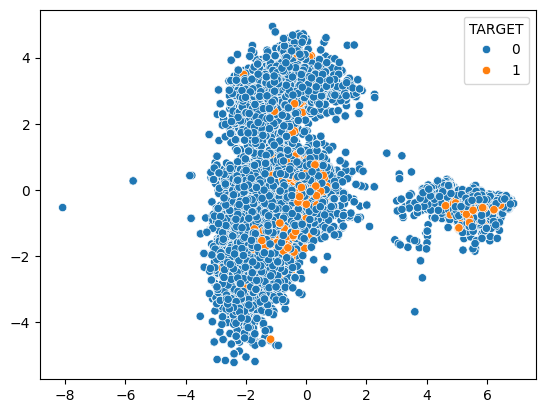

In [363]:
sns.scatterplot(x=d2_data[:, 0], y=d2_data[:, 1], hue=y_fin)
plt.show()
# BASELINE + OPTUNA

In [364]:
y_fin.mean()

np.float64(0.0999899734295884)

# DISTRIBUTION ANALYSIS

In [281]:
y_fin.value_counts(normalize=True).mul(100).round(2)

TARGET
0    70.0
1    30.0
Name: proportion, dtype: float64

In [288]:
for col in X_fin.columns:
    print(col)
    print(X_fin[col].value_counts(normalize=True).mul(100).round(2))
    print('\n')
    

CNT_CHILDREN
CNT_CHILDREN
0     72.48
1     19.40
2      7.08
3      0.87
4      0.12
5      0.04
14     0.01
7      0.00
19     0.00
Name: proportion, dtype: float64


AMT_INCOME_TOTAL
AMT_INCOME_TOTAL
135000    10.89
180000     8.75
225000     8.04
157500     7.81
112500     7.34
          ...  
519915     0.00
196628     0.00
88429      0.00
112047     0.00
164258     0.00
Name: proportion, Length: 4949, dtype: float64


DAYS_BIRTH
DAYS_BIRTH
13557    0.32
22182    0.32
9662     0.23
21363    0.22
24611    0.22
         ... 
23498    0.00
14835    0.00
11387    0.00
12825    0.00
22658    0.00
Name: proportion, Length: 11587, dtype: float64


DAYS_EMPLOYED
DAYS_EMPLOYED
365243    18.08
586        0.34
796        0.26
545        0.23
3420       0.21
          ...  
3884       0.00
3412       0.00
7147       0.00
5715       0.00
6823       0.00
Name: proportion, Length: 5601, dtype: float64


CNT_FAM_MEMBERS
CNT_FAM_MEMBERS
2     52.65
1     23.71
3     15.94
4      6.71
5      0.82
6

# BASELINE MODEL LOGREG

In [308]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [309]:
from sklearn.model_selection import train_test_split

In [310]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X_fin, y_fin, test_size=0.4, random_state=42, stratify=y_fin, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42, stratify=y_val_test, shuffle=True)

In [311]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [312]:
base_linear_model = LogisticRegression(max_iter=1000, class_weight='balanced')
base_linear_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [313]:
base_linear_model.score(X_test, y_test)

0.9531269582654468

In [314]:
roc_auc_score(y_test, base_linear_model.predict_proba(X_test)[:, 1])

0.9702555022844676

In [315]:
average_precision_score(y_test, base_linear_model.predict_proba(X_test)[:, 1])

0.9198327853919924

In [318]:
f1_score(y_test, base_linear_model.predict(X_test))

0.7896512935883014

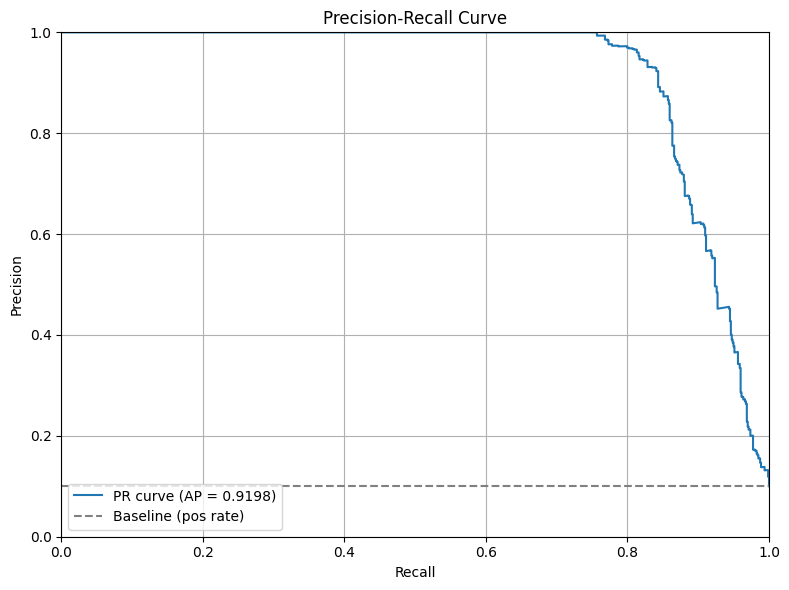

In [317]:
probas = base_linear_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probas)
ap_score = average_precision_score(y_test, probas)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.4f})')
plt.hlines(y=y_test.mean(), xmin=0, xmax=1, colors='gray', linestyles='--', label='Baseline (pos rate)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show() 

**Вывод**: Логистическая регрессия показала неплохо, ROC-AUC выше 0.9, Как и PR-AUC. Попробуем выбить качество лучше, используя нелинейные модели и балансировку классов.

# BASELINE MODEL CATBOOST

In [319]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

In [321]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X_fin, y_fin, test_size=0.4, random_state=42, stratify=y_fin, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42, stratify=y_val_test, shuffle=True)

In [323]:
base_catboost_model = CatBoostClassifier(iterations=3000, custom_metric=['AUC', 'F1', 'Recall', 'Precision', 'PRAUC'], task_type='GPU')
base_catboost_model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC, PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


In [324]:
roc_auc_score(y_test, base_catboost_model.predict_proba(X_test)[:, 1])

0.9976713821875396

In [325]:
average_precision_score(y_test, base_catboost_model.predict_proba(X_test)[:, 1])

0.9929961608288717

In [326]:
f1_score(y_test, base_catboost_model.predict(X_test))

0.9728706624605679

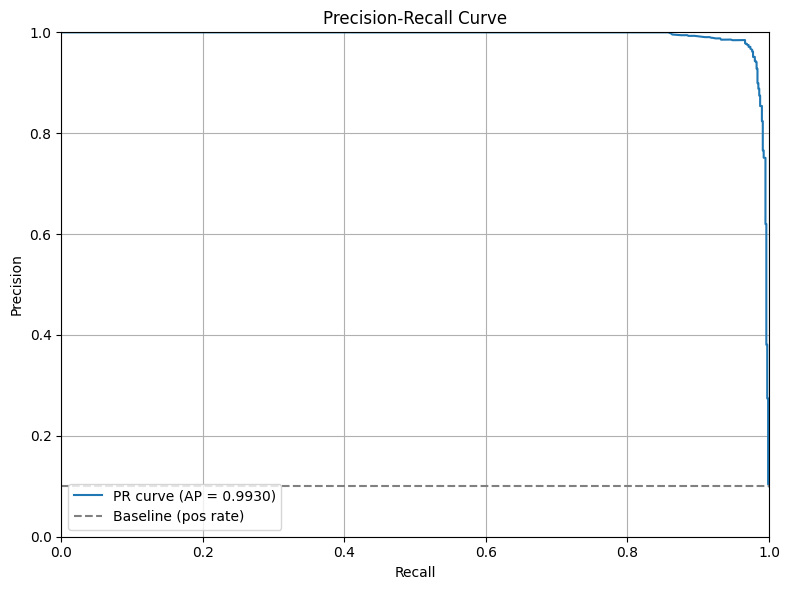

In [327]:
# Precision-Recall curve visualization
probas = base_catboost_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probas)
ap_score = average_precision_score(y_test, probas)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.4f})')
plt.hlines(y=y_test.mean(), xmin=0, xmax=1, colors='gray', linestyles='--', label='Baseline (pos rate)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show() 

**Вывод**: Катбуст улавливает больше нелинейных взаимосвязей и показывает намного лоучше резултаты, чем логистическая регрессия по целевым метриками. ROC-AUC выше 0.9, при этом PR-AUC тоже стал выше.

# BASELINE MODEL CATBOOST + CLASS BALANCE

In [328]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X_fin, y_fin, test_size=0.4, random_state=42, stratify=y_fin, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42, stratify=y_val_test, shuffle=True)

In [329]:
from catboost import CatBoostClassifier

In [332]:
balanced_catboost_model = CatBoostClassifier(
    custom_metric=['AUC', 'F1', 'Recall', 'Precision', 'PRAUC'], 
    task_type='GPU',
    auto_class_weights='Balanced'
    )
balanced_catboost_model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC, PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


In [333]:
roc_auc_score(y_test, balanced_catboost_model.predict_proba(X_test)[:, 1])

0.9979778160063856

In [334]:
average_precision_score(y_test, balanced_catboost_model.predict_proba(X_test)[:, 1])

0.9920059857516577

In [335]:
f1_score(y_test, balanced_catboost_model.predict(X_test))

0.946987951807229

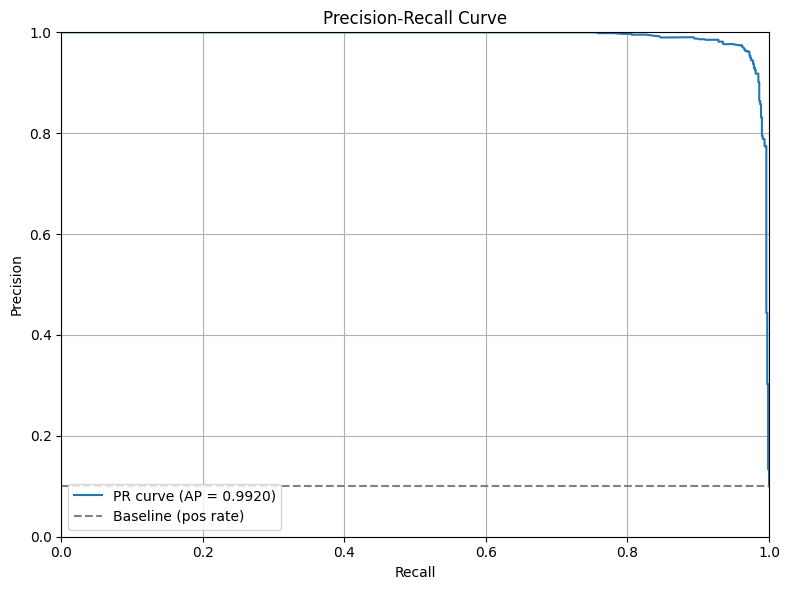

In [336]:
# Precision-Recall curve visualization
probas = balanced_catboost_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probas)
ap_score = average_precision_score(y_test, probas)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.4f})')
plt.hlines(y=y_test.mean(), xmin=0, xmax=1, colors='gray', linestyles='--', label='Baseline (pos rate)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show() 

In [339]:
sqrt_balanced_catboost_model = CatBoostClassifier(
    custom_metric=['AUC', 'F1', 'Recall', 'Precision', 'PRAUC'], 
    task_type='GPU',
    auto_class_weights='SqrtBalanced'
    )
sqrt_balanced_catboost_model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC, PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


In [340]:
roc_auc_score(y_test, sqrt_balanced_catboost_model.predict_proba(X_test)[:, 1])

0.9975509725434599

In [341]:
average_precision_score(y_test, sqrt_balanced_catboost_model.predict_proba(X_test)[:, 1])

0.991583588589165

In [342]:
f1_score(y_test, sqrt_balanced_catboost_model.predict(X_test))

0.9662921348314607

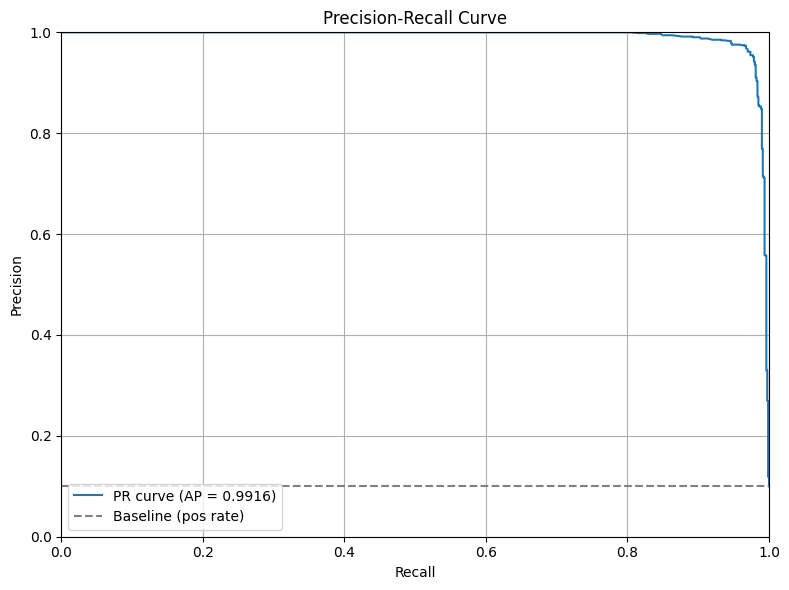

In [343]:
# Precision-Recall curve visualization
probas = sqrt_balanced_catboost_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probas)
ap_score = average_precision_score(y_test, probas)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.4f})')
plt.hlines(y=y_test.mean(), xmin=0, xmax=1, colors='gray', linestyles='--', label='Baseline (pos rate)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show() 

**Вывод**: Балансировка классов Balanced хоть и ухудшила AP но дало кривую лучше для подбора порога для максисизации Recall. А вот SqrtBqlqnced стартегия дала рост по всем ключевым метрикам (F1, RoC-AUC, PR-AUC). Пока что оставляем ее для финального теста.

# BASELINE + OPTUNA

In [374]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)


def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 1000, 3000, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 5.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 5.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 32),
        'auto_class_weights': 'SqrtBalanced',
    }

    model = CatBoostClassifier(
        **params,
        task_type='GPU',
        eval_metric='PRAUC',
        custom_metric=['AUC', 'F1', 'Recall', 'Precision', 'PRAUC'],
        random_seed=42,
    )

    model.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        use_best_model=True,
        early_stopping_rounds=100,
        verbose=False,
        plot=False,
    )

    preds = model.predict_proba(X_test)[:, 1]
    pr_auc = average_precision_score(y_test, preds)
    trial.set_user_attr('best_iteration', model.get_best_iteration())
    trial.set_user_attr('model', model)
    return pr_auc

X_train, X_val_test, y_train, y_val_test = train_test_split(X_fin, y_fin, test_size=0.4, random_state=42, stratify=y_fin, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42, stratify=y_val_test, shuffle=True)

study = optuna.create_study(direction='maximize', study_name='catboost_pr_auc')
study.optimize(objective, n_trials=5, timeout=3600, show_progress_bar=True)

print(f'Best PR-AUC: {study.best_value:.5f}')
print('Best parameters:')
for key, value in study.best_params.items():
    print(f'  {key}: {value}')

  0%|          | 0/5 [00:00<?, ?it/s]

Default metric period is 5 because AUC, PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Default metric period is 5 because AUC, PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Default metric period is 5 because AUC, PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented

Best PR-AUC: 0.99236
Best parameters:
  iterations: 1486
  depth: 10
  learning_rate: 0.02622640281129266
  l2_leaf_reg: 8.363546298963572
  bagging_temperature: 0.2793432273890295
  random_strength: 4.353853313774689
  border_count: 113
  grow_policy: Depthwise
  min_data_in_leaf: 26


In [375]:
best_model = study.best_trial.user_attrs['model']

In [376]:
study.best_trial.user_attrs['model'].save_model('optuna_model.cbm')

In [377]:
roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

0.9979816551544577

In [378]:
f1_score(y_test, best_model.predict(X_test))

0.9650436953807741

In [379]:
average_precision_score(y_test, best_model.predict_proba(X_test)[:, 1])

0.9923629746517302

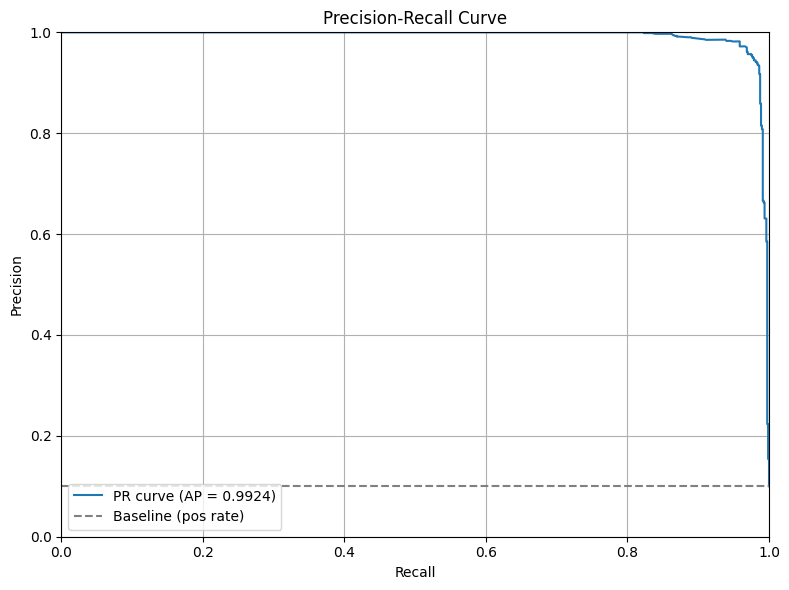

In [380]:
# Precision-Recall curve visualization
probas = best_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probas)
ap_score = average_precision_score(y_test, probas)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.4f})')
plt.hlines(y=y_test.mean(), xmin=0, xmax=1, colors='gray', linestyles='--', label='Baseline (pos rate)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show() 

**Вывод**: После перебора гиперпараметров PR-AUC стал еще выше. Берем эту версию для дальнейшего использование в продакшене.